<a href="https://colab.research.google.com/github/afhamash/GeneralizedFidelity/blob/main/Generalized_fidelity_plots.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Definitions

In [8]:
import numpy as np
import cvxpy as cp
import scipy as sp
import random
import time

from matplotlib import pyplot as plt
from matplotlib.ticker import MultipleLocator, AutoMinorLocator

from numpy import linalg as la
from numpy import sqrt as sqrt
from numpy import pi as pi
from scipy import linalg as sla
from scipy import optimize as opt
from scipy.optimize import minimize

from scipy.linalg import sqrtm as sqm
from numpy import trace as tr
from numpy import allclose as ac
from numpy.linalg import eigh as eigh
from numpy.linalg import norm as norm
from scipy.linalg import inv as inv
from scipy.linalg import pinv as pinv
from collections import Counter
from math import comb
from scipy.stats import unitary_group


rng = np.random.default_rng()
from numpy.linalg import norm
from scipy.stats import unitary_group as Unitary
# from matplotlib.colors import TwoSlopeNorm
from matplotlib import rc

# from sklearn.metrics import auc
# from scipy.stats import bernoulli
# from scipy.misc import derivative

In [9]:
# Initialize ggplot style for plots
plt.style.use('ggplot')
from matplotlib import rc
rc('animation', html='jshtml')
np.set_printoptions(precision = 4)

In [10]:
%matplotlib inline
from IPython.display import HTML

In [21]:
# Define Pauli matrices
PI = np.array([[1, 0],[0, 1]], dtype = 'complex128')
PX = np.array([[0, 1],[1, 0]], dtype = 'complex128')
PY = np.array([[0, 0 - 1j],[0 + 1j, 0]], dtype = 'complex128')
PZ = np.array([[1, 0],[0, -1]], dtype = 'complex128')

#Defined as a tuple since pauli matrices need not be changed later on
Paulis = (PI, PX, PY, PZ)

In [11]:
# Matrix Square root function
def MSR(P):
  D, V = sp.linalg.eigh(P)
  return (V * np.sqrt(np.abs(D))) @ V.conj().T

# Matrix Inverse funciton (for Invertible Hermitian matrices)
def MatInv(P):
  D, V = sp.linalg.eigh(P)
  return (V * 1/D) @ V.conj().T

def MatPower(P, pow):
  D, V = sp.linalg.eigh(P)
  return (V * D**pow) @ V.conj().T

# Matrix Log function
def LogM(P):
  D, V = sp.linalg.eigh(P)
  return (V * np.log(D)) @ V.conj().T

# Matrix Log (base 2) function
def LogM2(P):
  D, V = sp.linalg.eigh(P)
  return (V * np.log2(D)) @ V.conj().T

def ExpM(P):
  D, V = sp.linalg.eigh(P)
  return (V * np.exp(D)) @ V.conj().T

def ExpM2(P):
  D, V = sp.linalg.eigh(P)
  return (V * 2**D) @ V.conj().T

In [25]:
# Returns a complex Positive semidefinite matrix.
def PSDMatrix(Dim, Rank = None):
  if Rank is None:
    Rank = Dim
  X = 2*np.random.randn(Dim, Rank) - 1 + 1j*(2*np.random.randn(Dim, Rank) - 1)

  return X@(X.conj().T)


def DensityMatrix(Dim, Rank = None, IsReal = 0):
  if Rank is None:
    Rank = Dim

  if IsReal == 1:
    X = np.random.randn(Dim, Rank) # Generate random matrix
  else:
    X = np.random.randn(Dim, Rank) + 1j*(np.random.randn(Dim, Rank))

  P = X@X.conj().T   #Multiply by its transpose to obtain PSD matrix
  return P/np.trace(P)  #Normalise to obtain density matrix


# Return an n dimensional probability vector
def ProbVec(n):
  p = np.random.rand(n)
  return p/np.sum(p)

def HC(A):
  return A.conj().T

# Faster way of computing trace inner product
def TrInnerProduct(A,B):
  return float(np.real(np.dot(A.flatten().conj(), B.flatten().T)))

TIP = TrInnerProduct

def TraceDistance(Rho, Sigma):
  return la.norm(Rho - Sigma, 'nuc')

def UFidelity(P, Q):
  # Uhlmann Fidelity
  # return np.real(tr(sqm(Rho@Sigma)))
  SqP = MSR(P)
  return np.real(tr(MSR(SqP@Q@SqP)))

Fidelity = UFidelity


def MFidelity(P,Q):
  # Matsumoto fidelity
  return tr(GeoMean(P,Q))

def HFidelity(P,Q):
  # Holevo fidelity
  return TIP(MSR(P),MSR(Q))

UFidelity = Fidelity

def GenFidelity(P,Q,R):
  Rhf = MSR(R)
  return tr(MSR(Rhf@P@Rhf)@MatInv(R)@MSR(Rhf@Q@Rhf))

def GenBuresDistanceSq(P, Q, R):
  return np.real(tr(P) + tr(Q) - 2*(GenFidelity(P, Q, R)))

def BuresDistanceSq(P, Q):
  return np.real(tr(P) + tr(Q) - 2*Fidelity(P, Q))


def EucDistanceSq(P, Q):
  Delta = P - Q
  return np.real(TIP(Delta, Delta))


def IsSame(A, B, eps = 1e-8):
  return True if la.norm(A-B)<= eps else False


def GeoMean(P, Q):
  # Matrix Geometric Mean between two matrices
  Phf = MSR(P)
  Pihf = MatInv(Phf)

  return Phf@MSR(Pihf@Q@Pihf)@Phf

GM = GeoMean

def InvGeoMean(P, Q):

  Phf = MSR(P)
  Pihf = MatInv(Phf)

  return Pihf@MSR(Phf@Q@Phf)@Pihf

def BlochToDensity(x,z):

  return (PI + x*PX + z*PZ)/2

In [26]:
# Geodesic definitions
def BWGeodesic(P, Q, t):
  d = P.shape[0]
  S = InvGeoMean(P, Q)
  M = (1 - t)*np.eye(d) + t*S
  return M@P@M

def EucGeodesic(P, Q, t):
  return (1-t)*P + t*Q

def GenBurGeodesic(P, Q, R, t):
  d = P.shape[0]
  P_R = InvGeoMean(R, P)
  Q_R = InvGeoMean(R, Q)
  M = (1 - t)*P_R + t*Q_R
  return M@R@M

def AIGeodesic(P,Q,t):
  Phf = MSR(P)
  Pihf = pinv(Phf)b

  return Phf@sla.fractional_matrix_power(Pihf@Q@Pihf, t)@Phf


In [32]:
def Geodesic(P,Q,Metric,n, ToInv):

  Ts = np.linspace(0,1,n)

  if ToInv == 0:
    if Metric == 'BW':
      RList = []
      for t in Ts:
        R = BWGeodesic(P,Q,t)
        R = R/tr(R)
        RList.append(R)
      return RList

    elif Metric == 'AI':
      RList = []
      for t in Ts:
        R = AIGeodesic(P,Q,t)
        R = R/tr(R)
        RList.append(R)
      return RList

    elif Metric == 'Euc':
      RList = []
      for t in Ts:
        R = EucGeodesic(P,Q,t)
        R = R/tr(R)
        RList.append(R)
      return RList

  else:
    if Metric == 'BW':
      RList = []
      for t in Ts:
        R = MatInv(BWGeodesic(P,Q,t))
        R = R/tr(R)
        RList.append(R)
      return RList

    elif Metric == 'AI':
      RList = []
      for t in Ts:
        R = MatInv(AIGeodesic(P,Q,t))
        R = R/tr(R)
        RList.append(R)
      return RList

    elif Metric == 'Euc':
      RList = []
      for t in Ts:
        R = MatInv(EucGeodesic(P,Q,t))
        R = R/tr(R)
        RList.append(R)
      return RList

In [33]:
def BlochGeodesic(P,Q,Metric,n, ToInv):

  Rs = Geodesic(P,Q,Metric,n, ToInv)
  Rxs = []
  Rzs = []

  for R in Rs:
    Rxs.append(TIP(PX, R))
    Rzs.append(TIP(PZ, R))

  return Rxs, Rzs

# Generalized Fidelity on the Rebit Disk

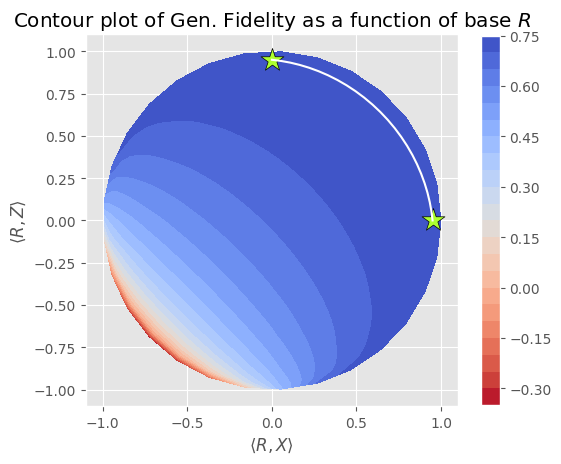

In [39]:


# Constants and setup
d = 2
eps = 0.05

# Define delta1 and delta2
delta1 = 0
theta1 = 2 * delta1 * pi
p = np.array((np.cos(theta1), np.sin(theta1))).T
P = np.outer(p, p)

delta2 = 1/8
theta2 = 2 * delta2 * pi
q = np.array((np.cos(theta2), np.sin(theta2))).T
Q = np.outer(q, q)


# Modify P2 and Q2 with epsilon perturbation




P2 = (1 - eps) * P + eps * np.eye(d) / d
Q2 = (1 - eps) * Q + eps * np.eye(d) / d


# P2 = DensityMatrix(d, IsReal=True)
# Q2 = DensityMatrix(d, IsReal=True)

# Create a grid for the unit disk
n_points = 30
theta = np.linspace(0, 2 * np.pi, n_points)
r = np.linspace(0, 0.999, n_points)

# Create a meshgrid in polar coordinates and convert to Cartesian coordinates
R_grid, Theta_grid = np.meshgrid(r, theta)
X = R_grid * np.cos(Theta_grid)
Y = R_grid * np.sin(Theta_grid)




# Evaluate GenFidelity at each point in the grid
Z = np.zeros_like(X)  # Initialize a grid to store fidelity values

for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        # For each point, construct the density matrix R based on (x, y) coordinates
        # R = DensityMatrix(d, IsReal=True)
        R = BlochToDensity(X[i, j], Y[i, j])
        # print(R)

        # Calculate the generalized fidelity and store it in Z
        Z[i, j] = np.real(GenFidelity(P2, Q2, R))


min_level = np.abs(Z).min()  # Get the minimum value of Z
max_level = Z.max()  # Get the maximum value of Z



# Use np.logspace to create logarithmic levels between min and max values
# levels = np.logspace(np.log10(min_level + 1e-6), np.log10(max_level), num=50)


# Create the contour plot
plt.figure(figsize=(6, 6))
contour = plt.contourf(X, Y, Z, levels=25, cmap='coolwarm_r')
# contour = plt.contourf(X, Y, Z, levels=levels, cmap='viridis')

P2i = MatInv(P2)
Q2i = MatInv(Q2)

P2iR = P2i/tr(P2i)
Q2iR = Q2i/tr(Q2i)




# plt.scatter(TIP(PX, P2iR), TIP(PZ, P2iR), marker = 'o', color = 'cyan', s = 100, edgecolor='black')
# plt.scatter(TIP(PX, Q2iR), TIP(PZ, Q2iR), marker = 'o', color = 'cyan', s = 100, edgecolor='black')


# Add a color bar to indicate the value of the contour levels
plt.colorbar(contour, shrink = 0.8)

# Set the axis limits to create a unit square
plt.xlim(-1.1, 1.1)
plt.ylim(-1.1, 1.1)


# Set the aspect ratio to ensure the plot is circular
plt.gca().set_aspect('equal', adjustable='box')

# Set axis labels
plt.xlabel(r'$\langle R,X \rangle$')
plt.ylabel(r'$\langle R,Z \rangle$' )

# plt.text(0, 0.8, r'$P = |0 \rangle \langle 0|$', fontsize=10, color='black', ha='center', va='center', backgroundcolor='white')
# plt.text(0.6, 0, r'$Q = |1 \rangle \langle  1|$', fontsize=10, color='black', ha='center', va='center', backgroundcolor='white')

# plt.text(-0.5, (1-0.0015)*UFid, '$\operatorname{F}^\mathrm{U}(P,Q)$', color='black', va='center', ha='center', backgroundcolor='none')


Ts = np.linspace(0,1,25)
R1ListX = []
R1ListY = []

R2ListX = []
R2ListY = []

# P = P2
# Q = Q2
# Pi = MatInv(P)
# Qi = MatInv(Q)

B1 = BlochGeodesic(P2,Q2,'BW',25,0)
plt.plot(B1[0], B1[1], color = 'white', linestyle = '-')
# B2 = BlochGeodesic(Pi,Qi,'AI',25,0)
# plt.plot(B2[0], B2[1], color = 'cyan', linestyle = '--')
# B2 = BlochGeodesic(P,Qi,'BW',25,0)
# plt.plot(B2[0], B2[1], color = 'lightgreen', linestyle = '--')
# B2 = BlochGeodesic(Pi,Q,'Euc',25,1)
# plt.plot(B2[0], B2[1], color = 'cyan', linestyle = '--')




plt.scatter(TIP(PX, P2), TIP(PZ, P2), marker = '*', color = 'greenyellow', s = 300, edgecolor='black')
plt.scatter(TIP(PX, Q2), TIP(PZ, Q2), marker = '*', color = 'greenyellow', s = 300, edgecolor='black')


# Set the title
plt.title(r'Contour plot of Gen. Fidelity as a function of base $R$')

plt.savefig('my_plot_trimmed.pdf', format='pdf', bbox_inches='tight')




# Display the plot
plt.show()



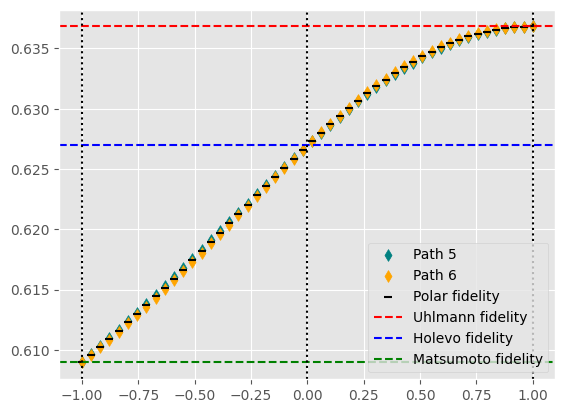

In [67]:
d = 3
P = DensityMatrix(d)
Q = DensityMatrix(d)

I = np.eye(d)




UFid = UFidelity(P,Q)
MFid = MFidelity(P,Q)
HFid = HFidelity(P,Q)

GFids1 = []
GFids2 = []

Phf = MSR(P)
Qhf = MSR(Q)

Pi = MatInv(P)
Qi = MatInv(Q)

Pihf = MatInv(Phf)
Qihf = MatInv(Qhf)


Ts = np.linspace(0,1,50)
for t in Ts:


  R1 = AIGeodesic(Pi, P, t)
  R2 = AIGeodesic(Qi, Q, t)

  Fid1 = GenFidelity(P, Q, R1)
  Fid2 = GenFidelity(P, Q, R2)

  GFids1.append(Fid1)
  GFids2.append(Fid2)

GFids1 = np.array(GFids1)
GFids2 = np.array(GFids2)

Ts = 2*np.array(Ts) - 1

# plt.figure(figsize=(6, 6))

plt.scatter(Ts, GFids1, marker = 'd', color = 'teal', label = 'Path 5')
plt.scatter(Ts, GFids2, marker = 'd', color = 'orange', label = 'Path 6')
plt.scatter(Ts, (GFids1 + GFids2)/2, marker = '_', color = 'black', label = 'Polar fidelity')

plt.axhline(y=UFid, color='r', linestyle='--', label='Uhlmann fidelity')
plt.axhline(y=HFid, color='b', linestyle='--', label='Holevo fidelity')
plt.axhline(y=MFid, color='g', linestyle='--', label='Matsumoto fidelity')


plt.axvline(x =-1, color='black', linestyle=':')
plt.axvline(x = 0, color='black', linestyle=':')
plt.axvline(x = 1, color='black', linestyle=':')


plt.legend()
